In [2]:
# Load dataset
import pandas as pd
import numpy as np
file_path =  r"D:\11thOCT25\11thOCT_satellite_merged_gridded_dataset_withallvar_complete.csv"
data = pd.read_csv(file_path)
data

,time,longitude,latitude,tcw,msl,blh,u10,v10,t2m,si10,...,e,tp,NDVI,EVI,tcco2,CO2,land,intl_bunker,ctco2,xco2_adjusted
0,2003-01-01,66.00,6.00,45.176895,101247.81,676.04126,-3.749901,-3.311073,299.79263,5.343475,...,-0.004431,0.004562,0.562498,0.275919,374.75494,0.0,0.000000,0.000177,374.05728,NaN
1,2003-01-01,66.25,6.00,45.125137,101247.31,666.44750,-3.707909,-3.247108,299.78287,5.278046,...,-0.004314,0.004593,0.567335,0.279492,374.75710,0.0,0.000000,0.000171,374.05838,NaN
2,2003-01-01,66.50,6.00,45.085100,101246.94,657.29126,-3.677147,-3.172401,299.77896,5.217987,...,-0.004202,0.004642,0.572173,0.283065,374.76270,0.0,0.000000,0.000157,374.05945,NaN
3,2003-01-01,66.75,6.00,45.070450,101246.06,653.47876,-3.655663,-3.106972,299.79263,5.177704,...,-0.004152,0.004726,0.577010,0.286638,374.76315,0.0,0.000000,0.000173,374.06042,NaN
4,2003-01-01,67.00,6.00,45.061660,101244.94,653.13500,-3.628807,-3.048866,299.80240,5.138641,...,-0.004141,0.004814,0.581848,0.290212,374.76337,0.0,0.000000,0.000179,374.06125,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3817363,2020-12-01,100.00,37.00,2.069163,102444.81,711.28820,3.042026,-0.179810,253.10182,4.455160,...,-0.000232,0.000154,0.090981,0.090981,414.97165,0.0,0.057796,0.000058,413.77267,NaN
3817364,2020-12-01,100.00,37.25,1.905100,102326.81,750.81946,2.547397,-0.947876,254.93385,4.356527,...,-0.000222,0.000137,0.097406,0.097406,414.97775,0.0,0.036596,0.000072,413.78754,NaN
3817365,2020-12-01,100.00,37.50,1.420725,102301.94,734.16320,3.185092,-0.326782,256.77760,3.943197,...,-0.000168,0.000118,0.122499,0.122499,414.92560,0.0,0.015396,0.000086,413.84090,NaN
3817366,2020-12-01,100.00,37.75,1.257639,102281.31,737.10070,3.564975,0.483765,257.32837,3.832357,...,-0.000161,0.000095,0.139643,0.139643,414.92865,0.0,0.048302,0.000100,413.87216,NaN


In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import time

# Start timing
start_time = time.time()


# Preprocess data
data['time'] = pd.to_datetime(data['time'])
data['year'] = data['time'].dt.year
data['month'] = data['time'].dt.month
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

feature_columns = ['latitude', 'longitude', 'ctco2', 't2m', 'skt', 'ssr', 'si10', 'tcw', 'u10', 'v10',
                   'tp', 'e', 'blh', 'msl', 'EVI', 'NDVI', 'CO2', 'land', 'intl_bunker', 'year', 'month_sin', 'month_cos']
target_column = 'xco2_adjusted'

# Data splitting
train_data = data[(data['year'] >= 2003) & (data['year'] <= 2017)]
unseen_data = data[(data['year'] >= 2018) & (data['year'] <=2020)]

X_train = train_data[feature_columns]
y_train = train_data[target_column]
X_test = unseen_data[feature_columns]
y_test = unseen_data[target_column]

# Scaling
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))


In [5]:
import tensorflow as tf
from keras.models import load_model
from keras.optimizers import AdamW
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def masked_logcosh_loss(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.is_nan(y_true))
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.cond(
        tf.equal(tf.size(y_true_masked), 0),
        lambda: tf.constant(0.0, dtype=tf.float32),
        lambda: tf.reduce_mean(tf.math.log(tf.cosh(tf.clip_by_value(y_pred_masked - y_true_masked, -10.0, 10.0))))
    )

def masked_mae_metric(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.is_nan(y_true))
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.cond(
        tf.equal(tf.size(y_true_masked), 0),
        lambda: tf.constant(0.0, dtype=tf.float32),
        lambda: tf.reduce_mean(tf.abs(y_pred_masked - y_true_masked))
    )

class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        self.dense1 = tf.keras.layers.Dense(input_shape[-1] // self.ratio, activation='relu')
        self.dense2 = tf.keras.layers.Dense(input_shape[-1], activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=1, keepdims=True)
        attention = self.dense1(avg_pool)
        attention = self.dense2(attention)
        return inputs * attention

class SpatialAttention(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.conv = tf.keras.layers.Dense(input_shape[-1], activation='sigmoid')

    def call(self, inputs):
        attention = self.conv(inputs)
        return inputs * attention


model = tf.keras.models.load_model(
    '150ep12thOCT25_best_model_optimized_continued.keras',
    custom_objects={
        'masked_logcosh_loss': masked_logcosh_loss,
        'masked_mae_metric': masked_mae_metric,
        'ChannelAttention': ChannelAttention,
        'SpatialAttention': SpatialAttention
    }
)

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_scaled, y_train_scaled, test_size=0.2, random_state=42)
model = build_model(input_dim=X_train_scaled.shape[1])
optimizer = AdamW(learning_rate=2e-4, weight_decay=1e-5, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=masked_logcosh_loss, metrics=[masked_mae_metric])



callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True, verbose=1),
    ModelCheckpoint(r'D:\11thOCT25\14thOCT_DNN\200ep12thOCT25_best_model_optimized_continued.keras', save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
]

history_continued = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    initial_epoch=150,  # Continue from epoch 76
    epochs=200,
    batch_size=96,
    callbacks=callbacks,
    verbose=1
)


Epoch 151/200
26508/26510 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1866 - masked_mae_metric: 0.0822
Epoch 151: val_loss improved from inf to 0.00114, saving model to D:\11thOCT25\14thOCT_DNN\200ep12thOCT25_best_model_optimized_continued.keras
26510/26510 ━━━━━━━━━━━━━━━━━━━━ 349s 12ms/step - loss: 0.1866 - masked_mae_metric: 0.0822 - val_loss: 0.0011 - val_masked_mae_metric: 0.0255 - learning_rate: 2.0000e-04
Epoch 152/200
26507/26510 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - masked_mae_metric: 0.0278
Epoch 152: val_loss improved from 0.00114 to 0.00059, saving model to D:\11thOCT25\14thOCT_DNN\200ep12thOCT25_best_model_optimized_continued.keras
26510/26510 ━━━━━━━━━━━━━━━━━━━━ 291s 11ms/step - loss: 0.0014 - masked_mae_metric: 0.0278 - val_loss: 5.9020e-04 - val_masked_mae_metric: 0.0239 - learning_rate: 2.0000e-04
Epoch 153/200
26508/26510 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2037e-04 - masked_mae_metric: 0.0221
Epoch 153: val_loss improved from 0.00059 to 0.00043,

In [6]:

y_val_pred_scaled = model.predict(X_val)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled).ravel()
y_val_actual = scaler_y.inverse_transform(y_val).ravel()
valid_mask = ~np.isnan(y_val_actual)

bias_model = LinearRegression()
bias_model.fit(y_val_pred[valid_mask].reshape(-1, 1), y_val_actual[valid_mask])

y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled).ravel()
y_pred_2020 = bias_model.predict(y_test_pred.reshape(-1, 1))

# --- Final Evaluation ---
valid_test_mask = ~np.isnan(y_test)
rmse = mean_squared_error(y_test[valid_test_mask], y_pred_2020[valid_test_mask], squared=False)
mae = mean_absolute_error(y_test[valid_test_mask], y_pred_2020[valid_test_mask])
r2 = r2_score(y_test[valid_test_mask], y_pred_2020[valid_test_mask])
correlation = np.corrcoef(y_test[valid_test_mask], y_pred_2020[valid_test_mask])[0, 1]

print(f"2020 RMSE: {rmse:.4f}")
print(f"2020 MAE: {mae:.4f}")
print(f"2020 R² Score: {r2:.4f}")
print(f"2020 Correlation: {correlation:.4f}")

# Save Predictions 
unseen_data['predicted_xco2'] = y_pred_2020
unseen_data[['time', 'latitude', 'longitude', 'xco2_adjusted', 'predicted_xco2']].to_csv(
    r'D:\11thOCT25\14thOCT_DNN\200ep_12thOCT25_optimized_predictions.csv', index=False
)


19883/19883 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step
19883/19883 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step
2020 RMSE: 1.3959
2020 MAE: 1.0524
2020 R² Score: 0.7820
2020 Correlation: 0.8868


C:\Users\digvi\AppData\Local\Temp\ipykernel_52140\4114827919.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unseen_data['predicted_xco2'] = y_pred_2020


In [6]:
import tensorflow as tf
from keras.models import load_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

def masked_logcosh_loss(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.is_nan(y_true))
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.cond(
        tf.equal(tf.size(y_true_masked), 0),
        lambda: tf.constant(0.0, dtype=tf.float32),
        lambda: tf.reduce_mean(tf.math.log(tf.cosh(tf.clip_by_value(y_pred_masked - y_true_masked, -10.0, 10.0))))
    )

def masked_mae_metric(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.is_nan(y_true))
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.cond(
        tf.equal(tf.size(y_true_masked), 0),
        lambda: tf.constant(0.0, dtype=tf.float32),
        lambda: tf.reduce_mean(tf.abs(y_pred_masked - y_true_masked))
    )

class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
    def build(self, input_shape):
        self.dense1 = tf.keras.layers.Dense(input_shape[-1] // self.ratio, activation='relu')
        self.dense2 = tf.keras.layers.Dense(input_shape[-1], activation='sigmoid')
    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=1, keepdims=True)
        attention = self.dense1(avg_pool)
        attention = self.dense2(attention)
        return inputs * attention

class SpatialAttention(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.conv = tf.keras.layers.Dense(input_shape[-1], activation='sigmoid')
    def call(self, inputs):
        attention = self.conv(inputs)
        return inputs * attention

# --- Load the best (continued) model ---
model = tf.keras.models.load_model(
    r'D:\11thOCT25\14thOCT_DNN\200ep12thOCT25_best_model_optimized_continued.keras',
    custom_objects={
        'masked_logcosh_loss': masked_logcosh_loss,
        'masked_mae_metric': masked_mae_metric,
        'ChannelAttention': ChannelAttention,
        'SpatialAttention': SpatialAttention
    }
)

print("\n✅ Loaded best continued model (epochs 76–125).")

# --- Prediction and Bias Correction ---
y_val_pred_scaled = model.predict(X_val)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled).ravel()
y_val_actual = scaler_y.inverse_transform(y_val).ravel()
valid_mask = ~np.isnan(y_val_actual)

bias_model = LinearRegression()
bias_model.fit(y_val_pred[valid_mask].reshape(-1, 1), y_val_actual[valid_mask])

y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled).ravel()
y_pred_2020 = bias_model.predict(y_test_pred.reshape(-1, 1))

# --- Final Evaluation ---
valid_test_mask = ~np.isnan(y_test)
rmse = mean_squared_error(y_test[valid_test_mask], y_pred_2020[valid_test_mask], squared=False)
mae = mean_absolute_error(y_test[valid_test_mask], y_pred_2020[valid_test_mask])
r2 = r2_score(y_test[valid_test_mask], y_pred_2020[valid_test_mask])
correlation = np.corrcoef(y_test[valid_test_mask], y_pred_2020[valid_test_mask])[0, 1]

print(f"\n=== Final Evaluation (Best Continued Model) ===")
print(f"2020 RMSE: {rmse:.4f}")
print(f"2020 MAE: {mae:.4f}")
print(f"2020 R² Score: {r2:.4f}")
print(f"2020 Correlation: {correlation:.4f}")

# --- Save Predictions ---
unseen_data['predicted_xco2'] = y_pred_2020
unseen_data[['time', 'latitude', 'longitude', 'xco2_adjusted', 'predicted_xco2']].to_csv(
    r'D:\11thOCT25\14thOCT_DNN\200ep_12thOCT25_optimized_predictions.csv', index=False
)

print("\n✅ Predictions saved to: final_125ep_12thOCT25_optimized_predictions.csv")



✅ Loaded best continued model (epochs 76–125).
19883/19883 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step
19883/19883 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step

=== Final Evaluation (Best Continued Model) ===
2020 RMSE: 1.3959
2020 MAE: 1.0524
2020 R² Score: 0.7820
2020 Correlation: 0.8868


C:\Users\digvi\AppData\Local\Temp\ipykernel_47460\3310330604.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unseen_data['predicted_xco2'] = y_pred_2020



✅ Predictions saved to: final_125ep_12thOCT25_optimized_predictions.csv


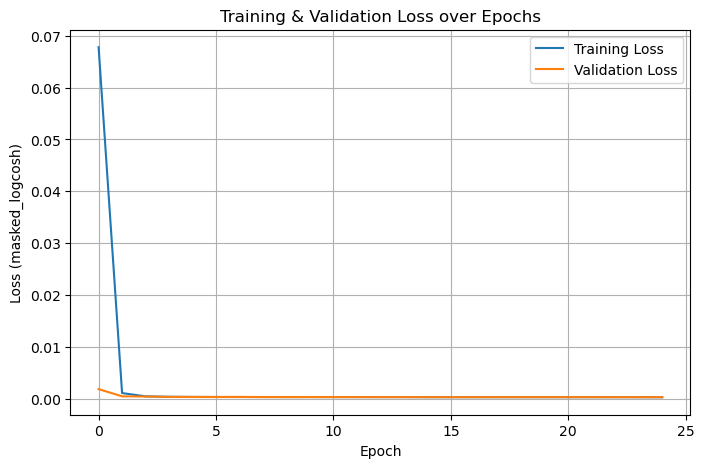

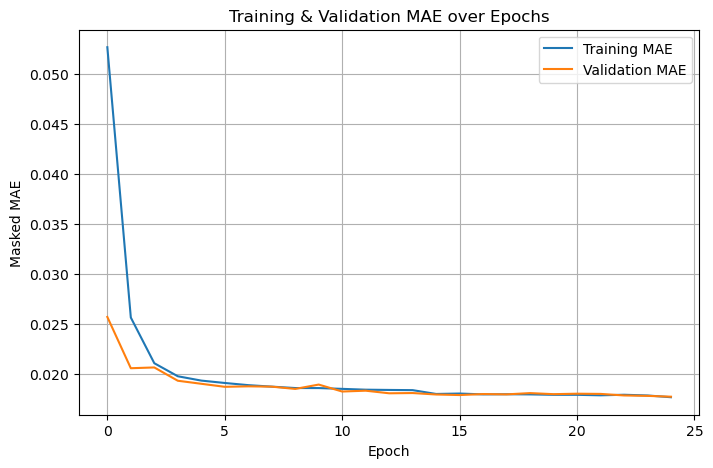

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

history_all = history_continued.history


plt.figure(figsize=(8, 5))
plt.plot(history_all['loss'], label='Training Loss')
plt.plot(history_all['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (masked_logcosh)')
plt.legend()
plt.grid(True)
plt.show()


if 'masked_mae_metric' in history_all:
    plt.figure(figsize=(8, 5))
    plt.plot(history_all['masked_mae_metric'], label='Training MAE')
    plt.plot(history_all['val_masked_mae_metric'], label='Validation MAE')
    plt.title('Training & Validation MAE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Masked MAE')
    plt.legend()
    plt.grid(True)
    plt.show()


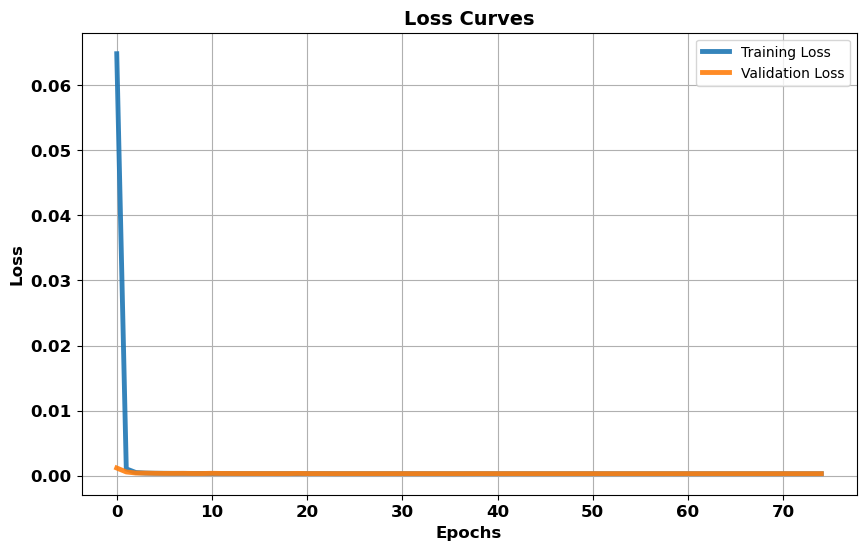

In [4]:
# Plot Training and Validation Loss from the 2nd epoch
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], alpha = 0.9, linewidth=3.5, label='Training Loss')
plt.plot(history.history['val_loss'],alpha = 0.9, linewidth=3.5, label='Validation Loss')
plt.xlabel('Epochs',fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Loss Curves',fontsize=14, fontweight='bold')
 # Make tick labels bold
plt.tick_params(axis='both', which='major', labelsize=12)
# Save the entire model (architecture + weights)
model.save(r'D:\11thOCT25\12thOCT25_BiasCorr_withCT_residual_dnn_xco2_model.h5')  # Save as HDF5 file (common format)


ax = plt.gca()  
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
plt.legend()
plt.grid()
plt.savefig(r'D:\11thOCT25\12thOCT25_BiasCorr_all_years_withCT_xco2_dnn_losses.png',dpi=600, bbox_inches='tight')
plt.show()


In [5]:
import pickle


with open(r'D:\11thOCT25\12thOCT_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [7]:
import pandas as pd
import numpy as np

# Step 1: Prepare the full dataset (2003–2020)
X_full = data[feature_columns]
y_full = data[target_column]

# Remove rows where any feature is NaN
valid_mask = ~X_full.isna().any(axis=1)
X_full_valid = X_full[valid_mask]
y_full_valid = y_full[valid_mask]
metadata_valid = data.loc[valid_mask, ['time', 'latitude', 'longitude']]

# Scale the data
X_full_scaled = scaler_X.transform(X_full_valid)
y_full_actual = y_full_valid.values

# Step 2: Predict xco2 for the entire range (2003–2020)
predicted_xco2_full = model.predict(X_full_scaled)
predicted_xco2_full_rescaled = scaler_y.inverse_transform(predicted_xco2_full).flatten()

# Step 3: Apply bias correction
predicted_xco2_corrected = bias_model.predict(predicted_xco2_full_rescaled.reshape(-1, 1))

# Step 4: Save predictions to CSV
full_csv_data = {
    "time": metadata_valid['time'],
    "latitude": metadata_valid['latitude'],
    "longitude": metadata_valid['longitude'],
    "xco2_adjusted": y_full_actual,
    "predicted_xco2": predicted_xco2_corrected.flatten()
}
full_df = pd.DataFrame(full_csv_data)
full_df.to_csv(r"D:\11thOCT25\14thOCT_DNN\200ep12thOCT_BiasCorr_withCT_xco2_predictions_2003_2020_direct.csv", index=False)
print("Saved predictions for 2003–2020 (direct approach) to 'xco2_predictions_2003_2020_direct.csv'.")


119293/119293 ━━━━━━━━━━━━━━━━━━━━ 494s 4ms/step
Saved predictions for 2003–2020 (direct approach) to 'xco2_predictions_2003_2020_direct.csv'.
